## MovieLen-100k data

## Initial setting for GGColab

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=955cfad0d3e60f29065838ef2b7709c7a87a7b7783ca4a9ae10302e01f1055de
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pwd

'/content'

In [4]:
%cd "/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als


In [5]:
%pwd

"/content/drive/Othercomputers/Tam's Laptop/Desktop/study/rec_sys/als"

## Preprocessing

In [105]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from recommenders.tuning.parameter_sweep import generate_param_grid
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

In [7]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("ALS rec sys").getOrCreate()

# Đọc tệp CSV vào DataFrame
mv_rating = spark.read.csv("data/ratings.csv", header=True, inferSchema=True)

# Hiển thị nội dung của DataFrame
mv_rating.show()


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [8]:
# Show random 5 rows:
mv_rating.sample(False, 0.1).show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1263|   2.0|1260759151|
|     1|   2193|   2.0|1260759198|
|     1|   2968|   1.0|1260759200|
|     2|    150|   5.0| 835355395|
|     2|    253|   4.0| 835355511|
+------+-------+------+----------+
only showing top 5 rows



In [9]:
# Count how many customer in the dataframe
mv_rating.createOrReplaceTempView('movielen')
spark.sql("SELECT Count(distinct userId) from movielen").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   671|
+----------------------+



In [10]:
# Add random age and gender to each user:
# age: random with range (18-50)
# gender: random in list (0: female, 1: male)
# --------------------------------------

# get distinct userid:
userids = spark.sql('select distinct userId from movielen').collect()
userids = [u['userId'] for u in userids]
print('user ids:', userids[:5])

# create a random age and gender dataframe for each userids:
random.seed(96)
user_age_gender_random_list = \
    [(u, random.randrange(18, 50), random.choice([0, 1])) for u in userids]
print('user_age_gender_random_list', user_age_gender_random_list[:5])

user_age_gender_random_df = spark.createDataFrame(
    user_age_gender_random_list, 
    ['userId', 'age', 'gender']
)
print('after random assigning age and gender:')
user_age_gender_random_df.show(5)

# merge to main df:
mv_rating = mv_rating.join(
    user_age_gender_random_df,
    on = 'userId',
    how = 'left'
)

user ids: [148, 463, 471, 496, 243]
user_age_gender_random_list [(148, 41, 1), (463, 43, 0), (471, 24, 1), (496, 20, 0), (243, 28, 1)]
after random assigning age and gender:
+------+---+------+
|userId|age|gender|
+------+---+------+
|   148| 41|     1|
|   463| 43|     0|
|   471| 24|     1|
|   496| 20|     0|
|   243| 28|     1|
+------+---+------+
only showing top 5 rows



In [11]:
# check null for all cols:
mv_rating.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in mv_rating.columns]
    ).show()

mv_rating.show(5)
mv_rating.printSchema()


+------+-------+------+---------+---+------+
|userId|movieId|rating|timestamp|age|gender|
+------+-------+------+---------+---+------+
|     0|      0|     0|        0|  0|     0|
+------+-------+------+---------+---+------+

+------+-------+------+----------+---+------+
|userId|movieId|rating| timestamp|age|gender|
+------+-------+------+----------+---+------+
|     1|     31|   2.5|1260759144| 36|     0|
|     1|   1029|   3.0|1260759179| 36|     0|
|     1|   1061|   3.0|1260759182| 36|     0|
|     1|   1129|   2.0|1260759185| 36|     0|
|     1|   1172|   4.0|1260759205| 36|     0|
+------+-------+------+----------+---+------+
only showing top 5 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: long (nullable = true)



## Train model:

In [12]:
# Assigning global variables:
USER_COL = "userId"
ITEM_COL = "movieId"
RATING_COL = "rating"
PREDICT_COL = "prediction"
REC_QUANTITY = 5


In [13]:
# train test split:
df_train, df_test = mv_rating.randomSplit([0.7, 0.3], seed = 96)

In [14]:
# TRAIN MODEL WITH DEFAULT PARAMS:
#---------------------------------
als = ALS(
    userCol=    USER_COL, 
    itemCol=    ITEM_COL, 
    ratingCol=  RATING_COL, 
    coldStartStrategy="drop")

model = als.fit(df_train)

In [15]:
# prediction on test dataset:
df_test_prd = model.transform(df_test)
df_test_prd.show()

+------+-------+------+----------+---+------+----------+
|userId|movieId|rating| timestamp|age|gender|prediction|
+------+-------+------+----------+---+------+----------+
|     1|     31|   2.5|1260759144| 36|     0| 2.0298116|
|     1|   1129|   2.0|1260759185| 36|     0| 2.6817844|
|     1|   1287|   2.0|1260759187| 36|     0| 2.6444678|
|     1|   1293|   2.0|1260759148| 36|     0| 3.1624713|
|     1|   1343|   2.0|1260759131| 36|     0|  2.556433|
|     1|   2968|   1.0|1260759200| 36|     0| 3.2264616|
|     2|     39|   5.0| 835355604| 27|     1|  3.448564|
|     2|     50|   4.0| 835355586| 27|     1|  3.543735|
|     2|    110|   4.0| 835355532| 27|     1| 3.8478765|
|     2|    153|   4.0| 835355441| 27|     1| 3.0922275|
|     2|    165|   3.0| 835355441| 27|     1| 3.0632827|
|     2|    185|   3.0| 835355511| 27|     1| 2.9438868|
|     2|    235|   3.0| 835355664| 27|     1|  2.427076|
|     2|    248|   3.0| 835355896| 27|     1| 2.1509347|
|     2|    265|   5.0| 8353556

In [16]:
# Evalualtion:
#------------------------------------------
evaluations = SparkRatingEvaluation(
    df_test, 
    df_test_prd,
    col_user=USER_COL,
    col_item=ITEM_COL,
    col_rating=RATING_COL,
    col_prediction=PREDICT_COL
)

print(
    "MSE score = {}".format(evaluations.rmse()**2),
    "RMSE score = {}".format(evaluations.rmse()),
    "MAE score = {}".format(evaluations.mae()),
    "R2 score = {}".format(evaluations.rsquared()),
    "Explained variance score = {}".format(evaluations.exp_var()),
    sep="\n"
)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE score = 0.8547896489475922
RMSE score = 0.9245483486262859
MAE score = 0.7131252019521062
R2 score = 0.22337642863413465
Explained variance score = 0.252158620562433


In [17]:
users = df_train.select(USER_COL).distinct()
items = df_train.select(ITEM_COL).distinct()
user_item = users.crossJoin(items)
user_item.show()

+------+-------+
|userId|movieId|
+------+-------+
|   148|   1580|
|   463|   1580|
|   471|   1580|
|   496|   1580|
|   243|   1580|
|   392|   1580|
|   540|   1580|
|   623|   1580|
|    31|   1580|
|   516|   1580|
|    85|   1580|
|   137|   1580|
|   251|   1580|
|   451|   1580|
|   580|   1580|
|    65|   1580|
|   458|   1580|
|    53|   1580|
|   255|   1580|
|   481|   1580|
+------+-------+
only showing top 20 rows



In [18]:
df_train_cross_pred = model.transform(user_item)
df_train_cross_pred.show()

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|   148|   1580| 4.0338526|
|   463|   1580| 3.5758436|
|   471|   1580|  3.891824|
|   496|   1580| 4.3777637|
|   243|   1580| 3.5465224|
|   392|   1580|  3.241222|
|   540|   1580| 4.1644015|
|   623|   1580|  4.015535|
|    31|   1580|  3.783456|
|   516|   1580| 3.8633132|
|    85|   1580|   3.68493|
|   137|   1580|  4.114218|
|   251|   1580|  4.113167|
|   451|   1580| 2.8043702|
|   580|   1580| 3.1552362|
|    65|   1580|  2.934329|
|   458|   1580| 3.5800447|
|    53|   1580| 2.9340665|
|   255|   1580| 3.3841193|
|   481|   1580| 3.5772972|
+------+-------+----------+
only showing top 20 rows



In [19]:
df_train.show()

+------+-------+------+----------+---+------+
|userId|movieId|rating| timestamp|age|gender|
+------+-------+------+----------+---+------+
|     1|   1029|   3.0|1260759179| 36|     0|
|     1|   1061|   3.0|1260759182| 36|     0|
|     1|   1172|   4.0|1260759205| 36|     0|
|     1|   1263|   2.0|1260759151| 36|     0|
|     1|   1339|   3.5|1260759125| 36|     0|
|     1|   1371|   2.5|1260759135| 36|     0|
|     1|   1405|   1.0|1260759203| 36|     0|
|     1|   1953|   4.0|1260759191| 36|     0|
|     1|   2105|   4.0|1260759139| 36|     0|
|     1|   2150|   3.0|1260759194| 36|     0|
|     1|   2193|   2.0|1260759198| 36|     0|
|     1|   2294|   2.0|1260759108| 36|     0|
|     1|   2455|   2.5|1260759113| 36|     0|
|     1|   3671|   3.0|1260759117| 36|     0|
|     2|     10|   4.0| 835355493| 27|     1|
|     2|     17|   5.0| 835355681| 27|     1|
|     2|     47|   4.0| 835355552| 27|     1|
|     2|     52|   3.0| 835356031| 27|     1|
|     2|     62|   3.0| 835355749|

In [20]:
# # Remove seen movies:
# df_train_cross_pred.createOrReplaceTempView('df_train_cross_pred')
# df_train.createOrReplaceTempView('df_train')

# df_train_exclude_seen_item_prd = spark.sql(f'''
#     SELECT 
#         pred.*
#     FROM df_train_cross_pred AS pred
#     FULL OUTER JOIN df_train AS train
#     ON pred.{USER_COL} = train.{USER_COL} AND pred.{ITEM_COL} = train.{ITEM_COL}
#     WHERE train.userId IS NULL
# ''')
# df_train_exclude_seen_item_prd.show()


In [21]:
# evaluations = SparkRankingEvaluation(
#     df_test, 
#     df_train_exclude_seen_item_prd,
#     col_user=USER_COL,
#     col_item=ITEM_COL,
#     col_rating=RATING_COL,
#     col_prediction=PREDICT_COL,
#     k = REC_QUANTITY
# )

# print(
#     "Precision@k = {}".format(evaluations.precision_at_k()),
#     "Recall@k = {}".format(evaluations.recall_at_k()),
#     "NDCG@k = {}".format(evaluations.ndcg_at_k()),
#     "Mean average precision = {}".format(evaluations.map_at_k()),
#     sep="\n"
# )

## Finetuning model

Prediction performance of a Spark ALS model is often affected by the parameters

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find the optimal combination of parameters. The following parameter set is used for training ALS models for comparison study purposes.

### 1st time:

In [24]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.001, 0.1, 1.0],
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 20, 'regParam': 0.001},
 {'rank': 20, 'regParam': 0.1},
 {'rank': 20, 'regParam': 1.0},
 {'rank': 30, 'regParam': 0.001},
 {'rank': 30, 'regParam': 0.1},
 {'rank': 30, 'regParam': 1.0},
 {'rank': 40, 'regParam': 0.001},
 {'rank': 40, 'regParam': 0.1},
 {'rank': 40, 'regParam': 1.0}]

In [25]:
rmse_score = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    
    evaluations = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(
    rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
    ) 

In [26]:
rmse_score_array

array([[1.6003, 0.9247, 1.3324],
       [1.6924, 0.9222, 1.3324],
       [1.8861, 0.9183, 1.3324]])

In [27]:
rmse_score

[1.6003, 0.9247, 1.3324, 1.6924, 0.9222, 1.3324, 1.8861, 0.9183, 1.3324]

<Axes: xlabel='reg. parameter', ylabel='rank'>

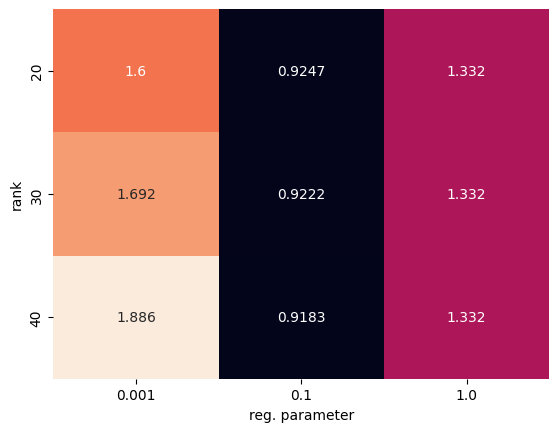

In [28]:

rmse_df = pd.DataFrame(data=rmse_score_array, index=pd.Index(param_dict["rank"], name="rank"), 
                       columns=pd.Index(param_dict["regParam"], name="reg. parameter"))

fig, ax = plt.subplots()
sns.heatmap(rmse_df, cbar=False, annot=True, fmt=".4g")

with rank 20 and reg is 0.1 is the best one, let's try again

### 2nd time

In [29]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.1]
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 20, 'regParam': 0.1},
 {'rank': 30, 'regParam': 0.1},
 {'rank': 40, 'regParam': 0.1}]

In [30]:
rmse_score_2 = []

for g in param_grid:
    als = ALS(        
        userCol=USER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    df_train_pred = model.transform(df_train).drop(RATING_COL)
    
    evaluations_test = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )
    evaluations_train = SparkRatingEvaluation(
        df_train, 
        df_train_pred,
        col_user=USER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score_2.append(
        (evaluations_train.rmse(), evaluations_test.rmse())
    )

# rmse_score = [float('%.4f' % x) for x in rmse_score]
# rmse_score_array = np.reshape(
#     rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
#     ) 

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [31]:
rmse_score_2

[(0.4903663173201702, 0.9247072784262896),
 (0.4624022265254126, 0.9221994956998573),
 (0.4507204461046799, 0.918320811985031)]

In [41]:
print('regParam', param_dict['regParam'])
pd.DataFrame(
    rmse_score_2, 
    columns = ['rmse_trainset', 'rmse_testset'], 
    index = param_dict['rank'])\
    .style.background_gradient()

regParam [0.1]


,rmse_trainset,rmse_testset
20,0.490366,0.924707
30,0.462402,0.922199
40,0.450720,0.918321


> The best param so far is: regParam = 0.1, rank = 40

## Train model again with: regParam = 0.1, rank = 40

In [50]:
als_fn = ALS(        
    userCol=USER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)

model = als_fn.fit(mv_rating)

## Top K Recommend for each customer

In [52]:
df_rec_user = model.recommendForAllUsers(REC_QUANTITY)

In [54]:
df_rec_user.show(truncate = False)

+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|1     |[{1172, 3.4042974}, {73290, 3.3754754}, {98491, 3.3669655}, {50, 3.32668}, {1968, 3.3225667}]       |
|2     |[{83411, 4.8596373}, {83359, 4.8596373}, {83318, 4.8596373}, {67504, 4.8596373}, {65037, 4.4671035}]|
|3     |[{83411, 4.7163424}, {83359, 4.7163424}, {83318, 4.7163424}, {67504, 4.7163424}, {65037, 4.5337057}]|
|4     |[{83411, 6.071324}, {83359, 6.071324}, {83318, 6.071324}, {67504, 6.071324}, {80599, 5.4641914}]    |
|5     |[{65037, 4.653016}, {59684, 4.653016}, {54328, 4.5897813}, {31435, 4.5660243}, {116, 4.547441}]     |
|6     |[{83411, 5.109644}, {83359, 5.109644}, {83318, 5.109644}, {67504, 5.109644}, {80599, 4.5986795}]    |
|7     |[{

In [59]:
# Expand recommendations:
df_rec_user_exp = df_rec_user.selectExpr(
    'userId', 'explode(recommendations) as recommendation'
    )
df_rec_user_exp.show()

+------+------------------+
|userId|    recommendation|
+------+------------------+
|     1| {1172, 3.4042974}|
|     1|{73290, 3.3754754}|
|     1|{98491, 3.3669655}|
|     1|     {50, 3.32668}|
|     1| {1968, 3.3225667}|
|     2|{83411, 4.8596373}|
|     2|{83359, 4.8596373}|
|     2|{83318, 4.8596373}|
|     2|{67504, 4.8596373}|
|     2|{65037, 4.4671035}|
|     3|{83411, 4.7163424}|
|     3|{83359, 4.7163424}|
|     3|{83318, 4.7163424}|
|     3|{67504, 4.7163424}|
|     3|{65037, 4.5337057}|
|     4| {83411, 6.071324}|
|     4| {83359, 6.071324}|
|     4| {83318, 6.071324}|
|     4| {67504, 6.071324}|
|     4|{80599, 5.4641914}|
+------+------------------+
only showing top 20 rows



In [63]:
df_rec_user_exp.select('recommendation').collect()[:5]

[Row(recommendation=Row(movieId=1172, rating=3.404297351837158)),
 Row(recommendation=Row(movieId=73290, rating=3.3754754066467285)),
 Row(recommendation=Row(movieId=98491, rating=3.3669655323028564)),
 Row(recommendation=Row(movieId=50, rating=3.3266799449920654)),
 Row(recommendation=Row(movieId=1968, rating=3.3225667476654053))]

In [67]:
# Get movieId from recommendation:
df_rec_user_exp = df_rec_user_exp.selectExpr(
    'userId',
    'recommendation.movieId as rec_movieId'
)
df_rec_user_exp.show()

+------+-----------+
|userId|rec_movieId|
+------+-----------+
|     1|       1172|
|     1|      73290|
|     1|      98491|
|     1|         50|
|     1|       1968|
|     2|      83411|
|     2|      83359|
|     2|      83318|
|     2|      67504|
|     2|      65037|
|     3|      83411|
|     3|      83359|
|     3|      83318|
|     3|      67504|
|     3|      65037|
|     4|      83411|
|     4|      83359|
|     4|      83318|
|     4|      67504|
|     4|      80599|
+------+-----------+
only showing top 20 rows



### Get movie names:

In [58]:
df_mv = spark.read.csv('data/movies.csv', header = True)
df_mv.show(truncate = False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [68]:
df_mv.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [74]:
# Get rec movie names, genres
df_rec_user_exp.alias('df1').join(
    df_mv.alias('df2'),
    on = expr('df1.rec_movieId = df2.movieId'),
    how = 'left'
)\
    .groupBy('userId')\
    .agg(
        collect_list('rec_movieId').alias('rec_movieId'),
        collect_list('title').alias('rec_movieName'),
        collect_list('genres').alias('rec_genres') 
    )\
    .show(truncate = False)

+------+------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|userId|rec_movieId                         |rec_movieName                                                                                                                                                                        |rec_genres                                                                                |
+------+------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
|1     |[1172, 73290, 98491, 50, 1968]     

In [145]:
mv_rating.orderBy(mv_rating['rating'].desc())\
    .toPandas()\
    .groupby('userId')['movieId'].agg(
        top_5_movieId_seen = lambda x: list(x)[:5]
        ).reset_index()

,userId,top_5_movieId_seen
0,1,"[1172, 1953, 2105, 1339, 1029]"
1,2,"[17, 39, 150, 222, 265]"
2,3,"[318, 356, 1197, 2959, 3949]"
3,4,"[34, 112, 141, 260, 296]"
4,5,"[597, 1035, 1380, 2081, 33166]"
...,...,...
666,667,"[32, 41, 144, 272, 296]"
667,668,"[296, 593, 608, 1213, 1221]"
668,669,"[260, 913, 1304, 2959, 223]"
669,670,"[25, 47, 50, 318, 527]"


# ALS with Age and Gender

In [75]:
mv_rating.show()

+------+-------+------+----------+---+------+
|userId|movieId|rating| timestamp|age|gender|
+------+-------+------+----------+---+------+
|     1|     31|   2.5|1260759144| 36|     0|
|     1|   1029|   3.0|1260759179| 36|     0|
|     1|   1061|   3.0|1260759182| 36|     0|
|     1|   1129|   2.0|1260759185| 36|     0|
|     1|   1172|   4.0|1260759205| 36|     0|
|     1|   1263|   2.0|1260759151| 36|     0|
|     1|   1287|   2.0|1260759187| 36|     0|
|     1|   1293|   2.0|1260759148| 36|     0|
|     1|   1339|   3.5|1260759125| 36|     0|
|     1|   1343|   2.0|1260759131| 36|     0|
|     1|   1371|   2.5|1260759135| 36|     0|
|     1|   1405|   1.0|1260759203| 36|     0|
|     1|   1953|   4.0|1260759191| 36|     0|
|     1|   2105|   4.0|1260759139| 36|     0|
|     1|   2150|   3.0|1260759194| 36|     0|
|     1|   2193|   2.0|1260759198| 36|     0|
|     1|   2294|   2.0|1260759108| 36|     0|
|     1|   2455|   2.5|1260759113| 36|     0|
|     1|   2968|   1.0|1260759200|

In [106]:
age_gender_rating_df = mv_rating.select(
    'userId',
    'movieId',
    'rating',
    concat(mv_rating['age'], mv_rating['gender']).alias('age_gender')
)\
    .groupBy(['age_gender', 'movieId'])\
    .agg(
        mean('rating').alias('rating')
    ).withColumn('age_gender', col('age_gender').cast(IntegerType()))
age_gender_rating_df.show()

+----------+-------+------------------+
|age_gender|movieId|            rating|
+----------+-------+------------------+
|       301|    720|               3.0|
|       301|   1653|               3.5|
|       341|   1413|               5.0|
|       341|   2357|               5.0|
|       361|   6537|               2.5|
|       340|   1270| 3.642857142857143|
|       281|   1801|               3.0|
|       281|   6377|               4.0|
|       491|   4664|               3.0|
|       391|    500|               3.0|
|       190|   2150|               4.0|
|       400|  68319|               5.0|
|       290|    750|               3.5|
|       200|    434|               3.2|
|       490|    786|               2.5|
|       470|    349|3.6666666666666665|
|       470|    722|               4.0|
|       470|   1015|2.6666666666666665|
|       470|   1681|              1.75|
|       470|   3089|               3.0|
+----------+-------+------------------+
only showing top 20 rows



In [100]:
AGE_GENDER_COL = 'age_gender'


### Evaluation

In [101]:
als = ALS(        
    userCol=AGE_GENDER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)
# model_agegender = als.fit(mv_rating)

In [102]:
param_dict = {
    "rank": [20, 30, 40],
    "regParam": [0.01, 0.1, 1]
    # 'maxIter': [7, 10, 15, 20]
}
param_grid = generate_param_grid(param_dict)
param_grid

[{'rank': 20, 'regParam': 0.01},
 {'rank': 20, 'regParam': 0.1},
 {'rank': 20, 'regParam': 1},
 {'rank': 30, 'regParam': 0.01},
 {'rank': 30, 'regParam': 0.1},
 {'rank': 30, 'regParam': 1},
 {'rank': 40, 'regParam': 0.01},
 {'rank': 40, 'regParam': 0.1},
 {'rank': 40, 'regParam': 1}]

In [108]:
rmse_score_3 = []
df_train, df_test = age_gender_rating_df.randomSplit([0.7, 0.3], seed = 96)

for g in param_grid:
    als = ALS(        
        userCol=AGE_GENDER_COL, 
        itemCol=ITEM_COL, 
        ratingCol=RATING_COL, 
        coldStartStrategy="drop",
        **g # assigning each of param
    )
    
    model = als.fit(df_train)
    
    df_test_pred = model.transform(df_test).drop(RATING_COL)
    df_train_pred = model.transform(df_train).drop(RATING_COL)
    
    evaluations_test = SparkRatingEvaluation(
        df_test, 
        df_test_pred,
        col_user=AGE_GENDER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )
    evaluations_train = SparkRatingEvaluation(
        df_train, 
        df_train_pred,
        col_user=AGE_GENDER_COL,
        col_item=ITEM_COL,
        col_rating=RATING_COL,
        col_prediction=PREDICT_COL
    )

    rmse_score_3.append(
        (evaluations_train.rmse(), evaluations_test.rmse())
    )

# rmse_score = [float('%.4f' % x) for x in rmse_score]
# rmse_score_array = np.reshape(
#     rmse_score, (len(param_dict["rank"]), len(param_dict["regParam"]))
#     ) 

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [109]:
rmse_score_3

[(0.2619944893196381, 1.5469571479788145),
 (0.45198921765877065, 0.9948259268658528),
 (1.2635839352150662, 1.3459900566441687),
 (0.17326671838536828, 1.6801343077367739),
 (0.41948368838772526, 0.9973116810425025),
 (1.2635839736955543, 1.3459900944230252),
 (0.12272558058700231, 1.7442408924795503),
 (0.40638492255117664, 0.989058802237946),
 (1.2635839079689413, 1.3459900345401934)]

In [126]:
pd.DataFrame(
    rmse_score_3, 
    columns = ['rmse_trainset', 'rmse_testset'],
    index = param_grid)\
    .reset_index()\
    .style.background_gradient()

,index,rmse_trainset,rmse_testset
0,"{'rank': 20, 'regParam': 0.01}",0.261994,1.546957
1,"{'rank': 20, 'regParam': 0.1}",0.451989,0.994826
2,"{'rank': 20, 'regParam': 1}",1.263584,1.345990
3,"{'rank': 30, 'regParam': 0.01}",0.173267,1.680134
4,"{'rank': 30, 'regParam': 0.1}",0.419484,0.997312
5,"{'rank': 30, 'regParam': 1}",1.263584,1.345990
6,"{'rank': 40, 'regParam': 0.01}",0.122726,1.744241
7,"{'rank': 40, 'regParam': 0.1}",0.406385,0.989059
8,"{'rank': 40, 'regParam': 1}",1.263584,1.345990


> best param is: rank = 40, regParam: 0.1

### Train model again with regParam = 0.1, rank = 40

In [127]:
als_fn = ALS(        
    userCol=AGE_GENDER_COL, 
    itemCol=ITEM_COL, 
    ratingCol=RATING_COL, 
    coldStartStrategy="drop",
    maxIter= 10, 
    regParam= 0.1,
    rank= 40
)

model_age_gender = als_fn.fit(age_gender_rating_df)